# Descripción del proyecto

La compañía *Sweet Lift Taxi* ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. 

## Objetivo
- Construir un modelo de machine learning para predecir la cantidad de pedidos de taxis para la próxima hora.
- Medir la calidad del modelo con la métrica RECM en el conjunto de prueba; obtener un score menor que 48.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación de datos

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model    import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_squared_error as mse

%matplotlib inline

In [2]:
# load data
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.sort_index(inplace=True)

In [3]:
# Check if dates and times are in chronological order
df.index.is_monotonic_increasing

True

In [4]:
print(f'Number of missing values: {df.isna().sum()}')

Number of missing values: num_orders    0
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


El dataset contiene información de 5 meses sobre el número de taxis que se pidieron entre el 1 marzo del 2018 a las 00:00:00 hasta 31 de agosto del 2018 a las 23:50:00, cada registro se hace cada 10 minutos. Con un total de 26496 observaciones.

## Análisis de datos

Primero vamos a cambiar el intervalo de nuestra serie temporal, realizando un remuestreo por hora a los datos.

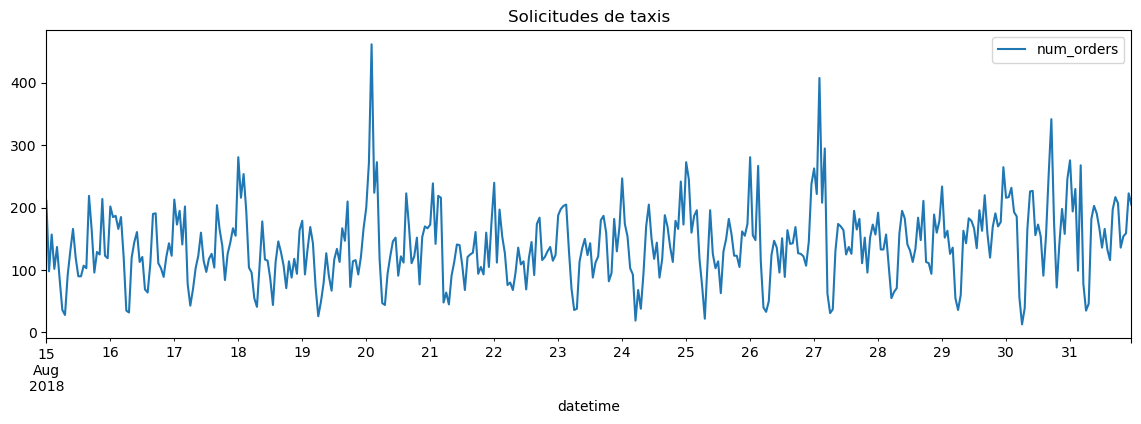

In [7]:
# Resample per hour
df = df.resample('1H').sum()
df['2018-08-15':'2018-08-31'].plot(figsize=(14,4))
plt.title('Solicitudes de taxis')
plt.show()

Observamos en nuestra muestra que existe cierto comportamiento en nuestros datos, vamos a revisar mejor obteniendo la tendencia, estancionalidad y residuos de:

  - 2 últimos meses
  - 6 últimos días

### Pedidos de taxi en los últimos 2 meses

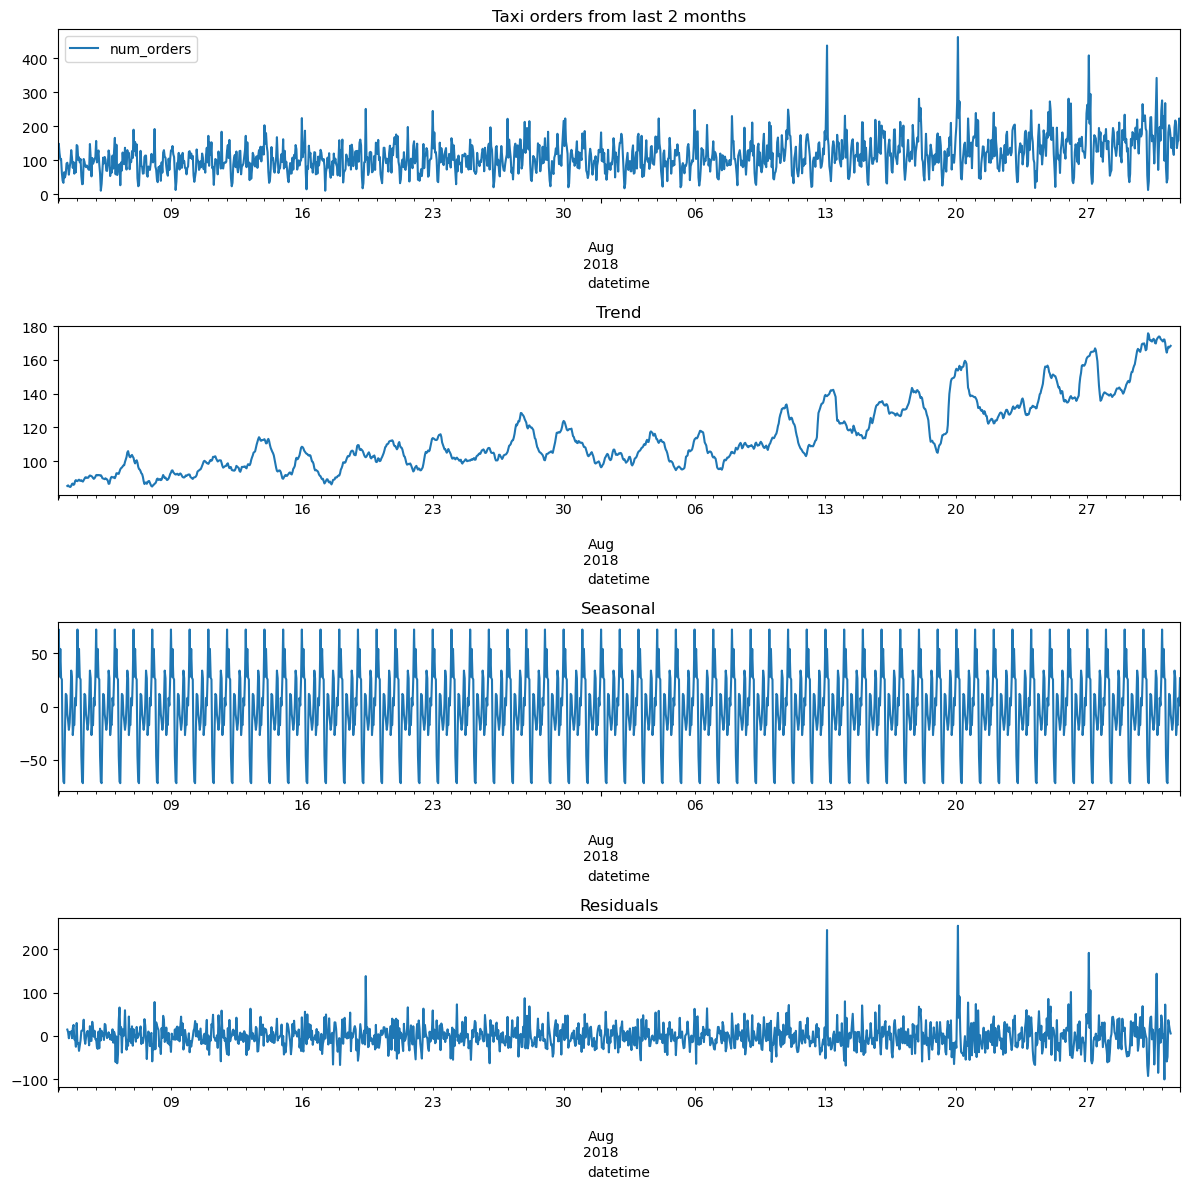

In [8]:
# last 2 months

days=60
start = df.index.max() - pd.Timedelta(days=days)
end = df.index.max()

decomposed = seasonal_decompose(df[start:end])

plt.figure(figsize=(12, 12))

# Original data
plt.subplot(411)
df[start:end].plot(ax=plt.gca())
plt.title('Taxi orders from last 2 months')

# Trends
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Seasonality
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

# Residuals
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Observamos los números de órdenes de taxis de los últimos 2 meses, observamos que nuestra serie temporal no es estacionaria; existe una tendencia clara creciente y estacionalidad patrones repetitivos diarios.

### Pedidos de taxi en los últimos 6 días

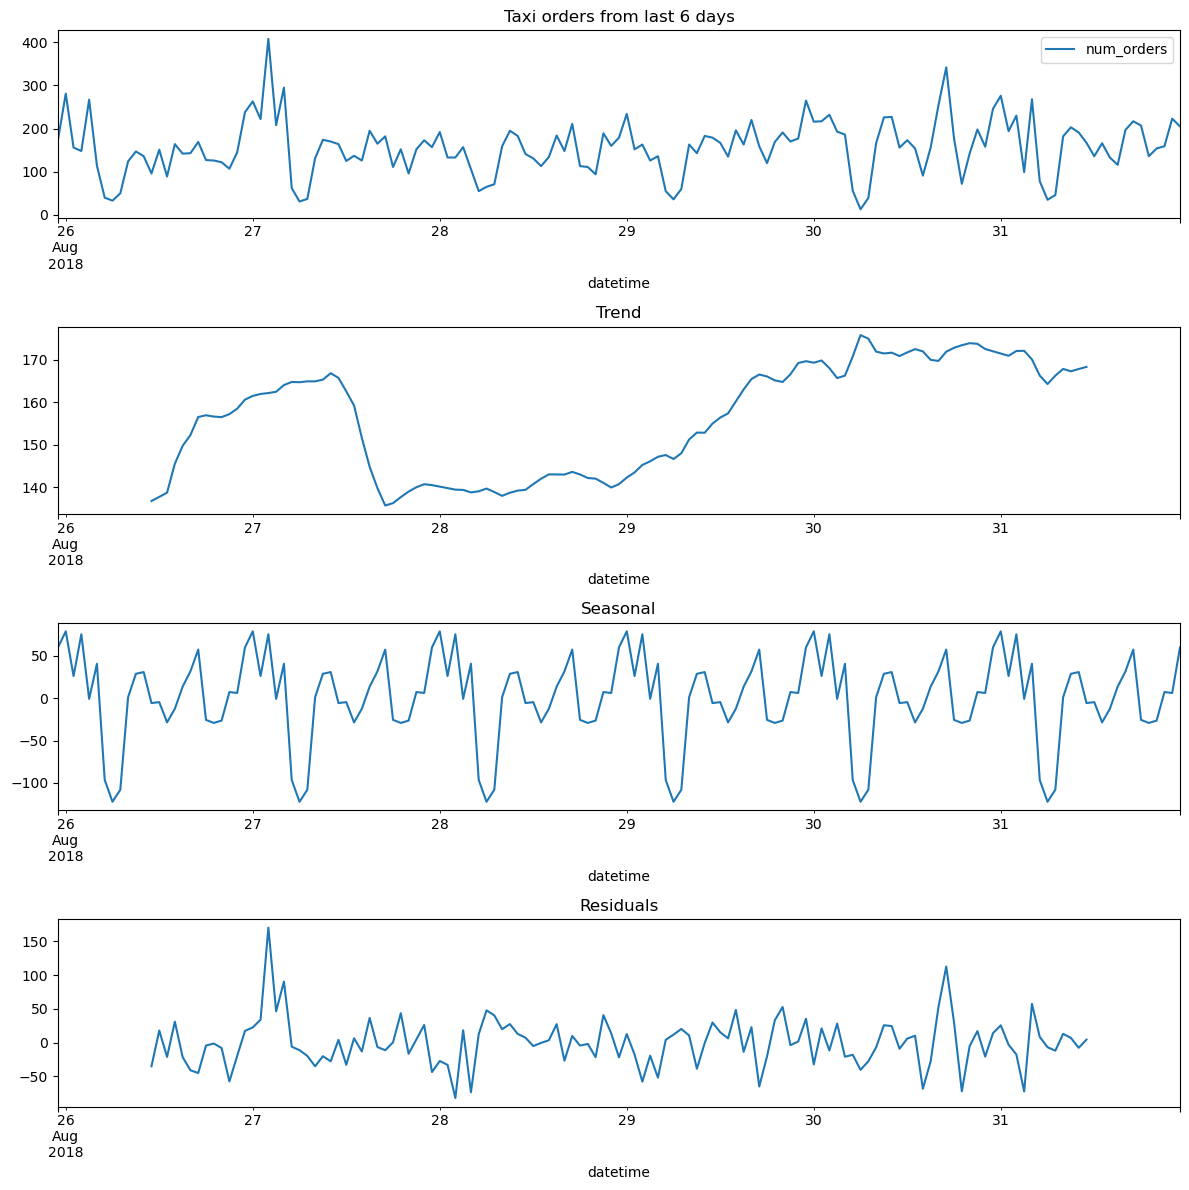

In [9]:
# last 6 days

days=6
start = df.index.max() - pd.Timedelta(days=days)
end = df.index.max()

decomposed = seasonal_decompose(df[start:end])

plt.figure(figsize=(12, 12))

# Original data
plt.subplot(411)
df[start:end].plot(ax=plt.gca())
plt.title('Taxi orders from last 6 days')

# Trends
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Seasonality
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

# Residuals
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Analizamos las horas de los últimos 6 dias, y notamos que existe una tendencia general creciente, las órdenes de taxis van incrementando levemente con el paso del tiempo, además los datos son estacionarios, ya que se nota un patrón repetitivo, cada día en las primeras horas de la mañana hay un pico que cae, en el dia existen picos altos y sobre todo en altas horas de la noche puede haber muchas carreras de taxi.La gráfica de residuo nos proporciona información sobre las fluctuaciones no explicadas por la tendencia y la estacionalidad.

## Comprobar estacionariedad

De acuerdo a las gráficas anteriores, observamos que nuestra serie temporal no es estacionaria, por lo que vamos a convertirla realizando una diferenciación.

In [10]:
# Take the first difference to remove to make the process stationary
df.num_orders = df.num_orders - df.num_orders.shift()
# df = pd.Series(df, index=df.index)
df.dropna(inplace=True)

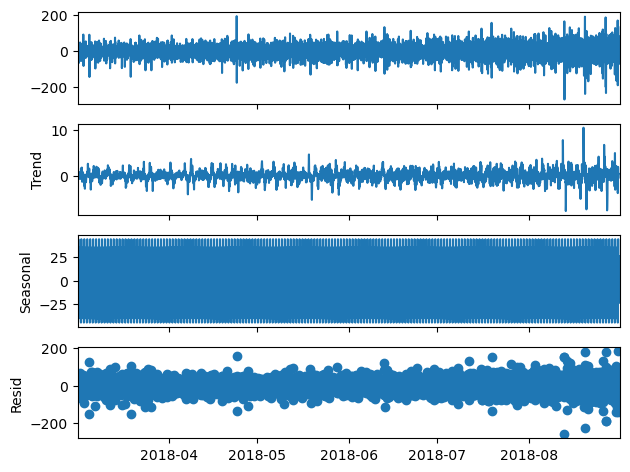

In [11]:
result = seasonal_decompose(df)
result.plot();

Listo, hemos ayudado a que nuestra serie sea estacionaria, observamos que ya no existe una tendencia en nuestros datos. Ahora estamos listo para empezar nuestros entrenamientos.

# Entrenamiento de modelos 

Vamos a entrenar varios modelos para predecir el número de órdenes de taxi en la siguiente hora y realizaremos la evaluación con la métrica RECM.


Crearemos una funcion para crear características basadas en nuestra serie temporal.

In [12]:
# Function to create features

def make_features(df, max_lag, rolling_mean_size):

    """
    parameters:
    "df" is the dataset with our target
    "max_lag" is the number of the lags to use
    "rolling_mean_size" is size of the window for media movil
    
    return features
    """
    
    df_with_features = df.copy()
    df_with_features['month'] = df.index.month
    df_with_features['day'] = df.index.day
    df_with_features['dayofweek'] = df.index.dayofweek
    df_with_features['hour'] = df.index.hour

    # lags values
    for lag in range(1, max_lag + 1):
        df_with_features['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # Media movil
    df_with_features['rolling_mean'] = (df['num_orders'].shift().rolling(rolling_mean_size).mean())

    return df_with_features

In [13]:
# Create df with other features
lags = 15
rolling_mean = 6
df_with_features = make_features(df, lags, rolling_mean)

In [14]:
# Train-test data segmentation
train, test = train_test_split(df_with_features, test_size=0.1, shuffle=False)
train.dropna(inplace=True)

# Features and target
X_train = train.drop('num_orders', axis=1)
X_test =  test.drop('num_orders', axis=1)

y_train = train['num_orders']
y_test  = test['num_orders']

# Check size
print(f'Train: {train.index.min()} --- {train.index.max()}  (n={len(train)})')
print(f'Test : {test.index.min()} --- {test.index.max()}  (n={len(test)})')

Train: 2018-03-01 16:00:00 --- 2018-08-13 13:00:00  (n=3958)
Test : 2018-08-13 14:00:00 --- 2018-08-31 23:00:00  (n=442)


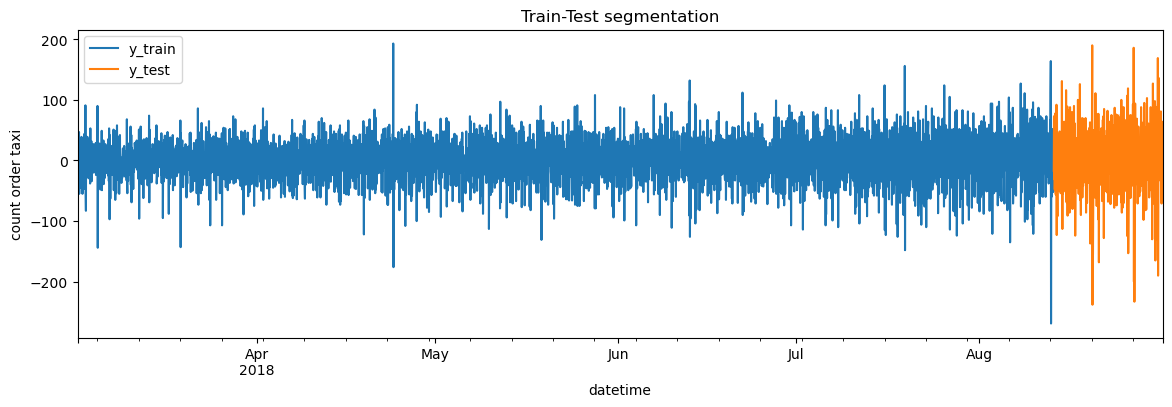

In [15]:
# Plot train-test segmentation
fig, ax = plt.subplots(figsize=(14, 4))
y_train.plot(ax=ax, label='y_train')
y_test.plot(ax=ax, label='y_test')
plt.ylabel('count order taxi')
plt.title('Train-Test segmentation')
ax.legend()
plt.show()

In [16]:
# Function grid_search
def grid_search_cv(estimator, params, X, y):
    
    '''
    parameters:
    "estimator": algorithm to train
    "params": hyperparameters
    "x": features
    "y": target

    return: the best parameters
    
    '''
    tscv = TimeSeriesSplit(n_splits=5)
   
    grid_search= GridSearchCV(estimator=estimator, 
                              param_grid=params, 
                              scoring='neg_root_mean_squared_error', 
                              cv=tscv)

    grid_search.fit(X, y)

    max_score = grid_search.cv_results_['mean_test_score'].max()

    index_max_score = np.where(grid_search.cv_results_['mean_test_score'] == max_score)[0][0]
    best_params = grid_search.cv_results_['params'][index_max_score]

    print(f'Best hiperparameters: {best_params}')
    return best_params

In [17]:
# Save the metrics of the models
summary_models = pd.DataFrame(columns=['model', 'rmse'])

## Modelo 1: Linear Regression

In [18]:
# Model with Linear Regression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
pred_lr = pd.Series(y_pred_lr, index=y_test.index)

rmse = mean_squared_error(y_test, pred_lr, squared=False) 
rmse = round(rmse, 2)

summary_models.loc[1] = {'model': 'LinearRegression', 'rmse': rmse}

print('RECM', rmse)

RECM 51.36


In [19]:
# Specific number days for the graph

days=2

start_train = train.index.max() - pd.Timedelta(days=days)
end_train = train.index.max()
start_test = test.index.min()
end_test = test.index.min() + pd.Timedelta(days=days)

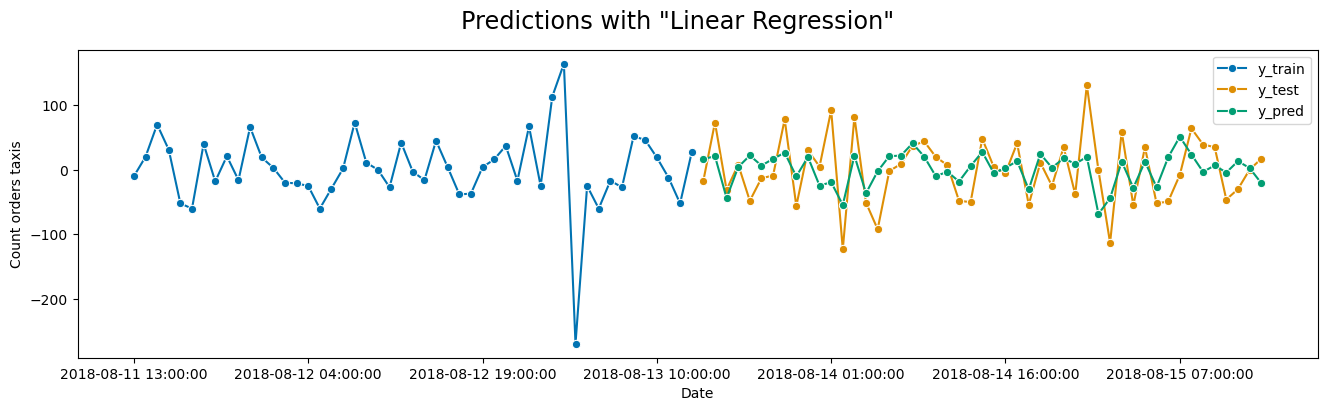

In [20]:
# Plot

plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lr[start_test:end_test], 
            labels=["y_train", "y_test", "y_pred"], 
            x_label='Date', 
            y_label='Count orders taxis',
            title='Predictions with "Linear Regression"');

Nuestro modelo fue entrenado con *Regresion Lineal*, y obteniendo un RECM de 51, debemos mejorarlo.

## Modelo 2: Decision Tree Regressor

In [21]:
# Tuning hyperparameters:

params_dt = {'max_depth': range(4,20,2),
             'min_samples_split': range(4,20,2),
             'min_samples_leaf': range(4,20,2)
             }

params = grid_search_cv(DecisionTreeRegressor(), params_dt, X_train, y_train)

Best hiperparameters: {'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 6}


In [22]:
# Training DecisionTreeRegressor

model_dt = DecisionTreeRegressor(max_depth = params['max_depth'],
                                 min_samples_leaf= params['min_samples_leaf'],
                                 min_samples_split = params['min_samples_split']
                                 )

model_dt.fit(X_train, y_train)

pred_dt = model_dt.predict(X_test)
pred_dt = pd.Series(pred_dt, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_dt, squared=False), 2)

summary_models.loc[2] = {'model': 'DecisionTreeRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_dt.get_params())

RMSE 49.25
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 16, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


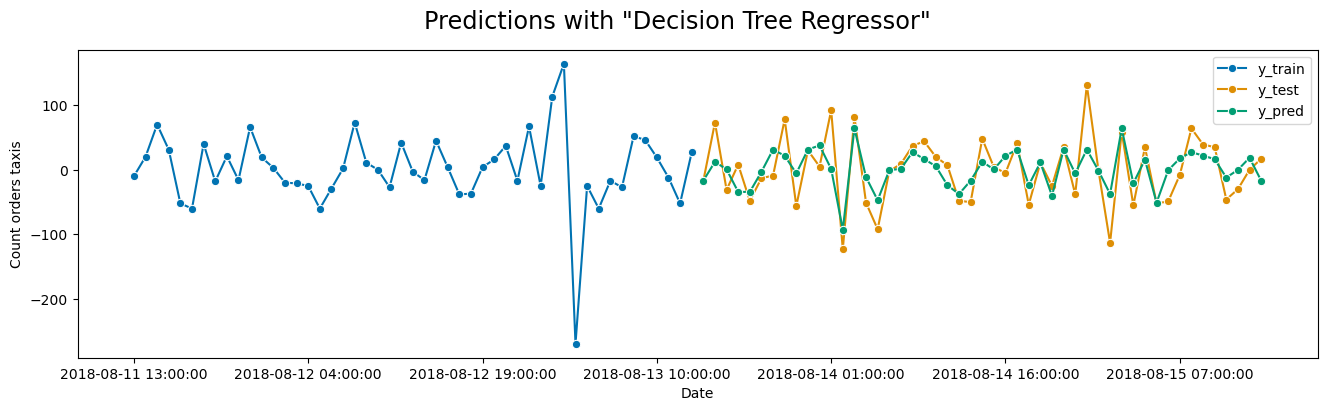

In [23]:
# Plot 
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_dt[start_test:end_test], 
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis', 
            title='Predictions with "Decision Tree Regressor"');

Hemos ajustado nuestros hiperparámetros de nuestro árbol de decisión, y hemos obtenido un score de 49, ciertamente ha mejorado, pero aún debemos ajustarlo. Intentemos ahora con *Random Forest*.

## Modelo 3: Random Forest Regressor

In [24]:
# Tuning hyperparameters:

params_rf = {'max_depth': range(4,20,2),
             'n_estimators': range(4,40,2),
             }

params = grid_search_cv(RandomForestRegressor(), params_rf, X_train, y_train)

Best hiperparameters: {'max_depth': 18, 'n_estimators': 36}


In [25]:
# Training RandomForestRegressor

model_rf = RandomForestRegressor(max_depth = params['max_depth'],
                                 n_estimators= params['n_estimators'],
                                 )

model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)
pred_rf = pd.Series(pred_rf, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_rf, squared=False), 2)

summary_models.loc[3] = {'model': 'RandomForestRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_rf.get_params())

RMSE 44.58
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 36, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


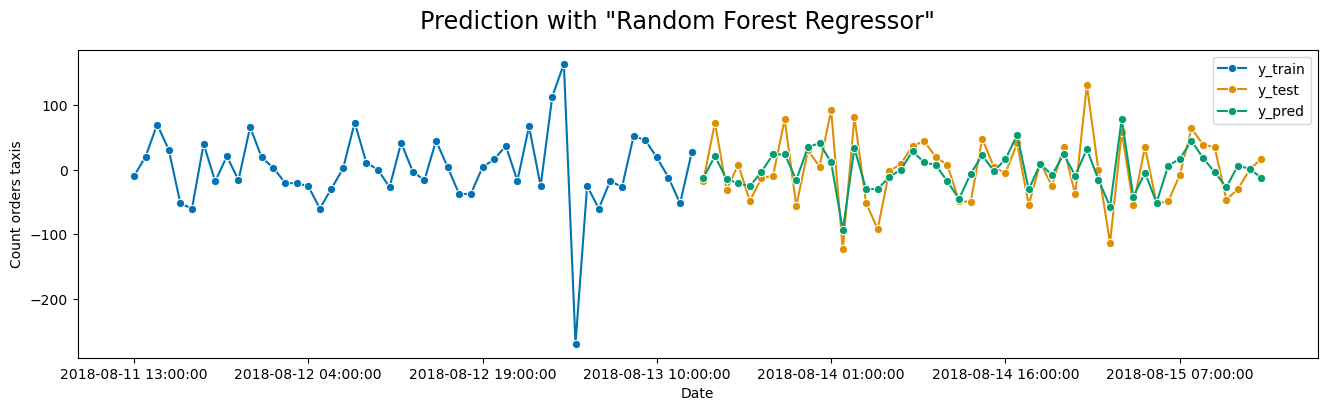

In [26]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_rf[start_test:end_test], 
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis', 
            title='Prediction with "Random Forest Regressor"');

Hemos obtenido un buen modelo con un score de 44 después de haber realizado un tuning de hiperparámetros, por lo que el Random Forest hasta el momento es el mejor modelo.

## Modelo 4: LGBMRegressor

In [27]:
# Tuning hyperparameters:

param_lgbm = {'num_leaves': [10, 20, 30],
              'learning_rate': [0.1, 0.5],
              'max_depth': [-1,5],
              'n_estimators': [10, 50, 100]
              }

params = grid_search_cv(LGBMRegressor(), param_lgbm, X_train, y_train)

Best hiperparameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 20}


In [28]:
# Training LGBMRegressor

model_lgbm = LGBMRegressor(learning_rate= params['learning_rate'],
                             max_depth= params['max_depth'],
                             n_estimators= params['n_estimators'],
                             num_leaves = params['num_leaves'])

model_lgbm.fit(X_train, y_train)

pred_lgbm = model_lgbm.predict(X_test)
pred_lgbm = pd.Series(pred_lgbm, index=y_test.index)
rmse = round(mean_squared_error(y_test, pred_lgbm, squared=False), 2)

summary_models.loc[4] = {'model': 'LGBMRegressor', 'rmse': rmse}

print(f'RMSE {rmse}')
print(model_lgbm.get_params())

RMSE 42.48
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


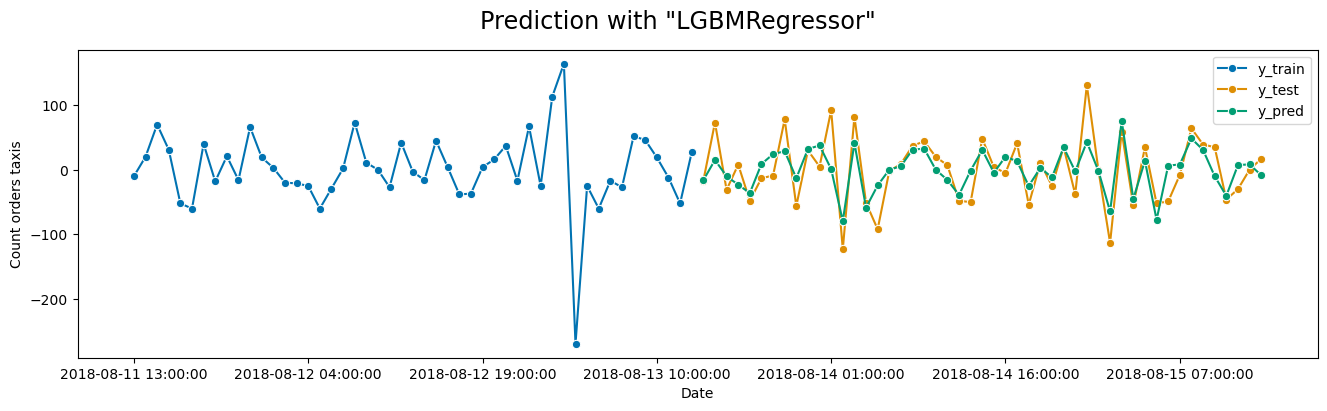

In [29]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbm[start_test:end_test], 
            labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count orders taxis', 
            title='Prediction with "LGBMRegressor"');

Hemos obtenido un buen resultado, el modelo LGBMRegressor con ajuste de hiperparámetros obtuvo un buen score de 42 superando a Random Forest.

## Modelo 5: Recursive Tabular Regression "RandomForestRegressor" Forecaster 

Podemos usar la reducción para transformar una tarea de pronóstico en un problema de regresión tabular. Esto significa que podemos resolver una tarea de pronóstico utilizando los estimadores de scikit-learn con Random Forest.

Usaremos `make_reduction` de la libreria `sktime`, para generar un forecaster basado en reducción, utilizando modelos de regresión de scikit-learn: LinearRegression, RandomForestRegressor.

- La función `make_reduction` transforma las series temporales en datos tabulares compatibles con nuestro estimador (LinearRegression, RandomForest, etc).  El parámetro, `window_length`, controla el número de retrasos en nuestra transformación de ventana deslizante.

- Usaremos `ForecastingHorizon()` dándole el índice de nuestra serie tiempo de test para generar el horizonte de pronóstico; este contendrá las marcas de tiempo para las que  se desea generar un pronóstico obtenido de los datos de prueba: y_test. Esto significa que se desea generar un pronóstico por hora para cada uno de esos 18 días.

In [30]:
# Forecasting horizon, same as test data
fh = ForecastingHorizon(y_test.index, is_relative=False) # Predict from the last 442 hours (18 days)

regressor = LGBMRegressor(max_depth= 3,
                          n_estimators= 30,
                          num_leaves = 5,
                          learning_rate=0.01
                          )

# Linear regression forecaster
model_frf = make_reduction(estimator= regressor, strategy='recursive', window_length= 10)

# Fit and predict
model_frf.fit(y_train)
pred_lgbmf = model_frf.predict(fh)

# Evaluate with rmse
rmse = round(mse(y_test, pred_lgbmf, square_root=True), 2) # square_root=True for rmse
summary_models.loc[5] = {'model': 'LGBMRegressor Forecaster', 'rmse': rmse}

print('\nRECM:', rmse)


RECM: 58.87


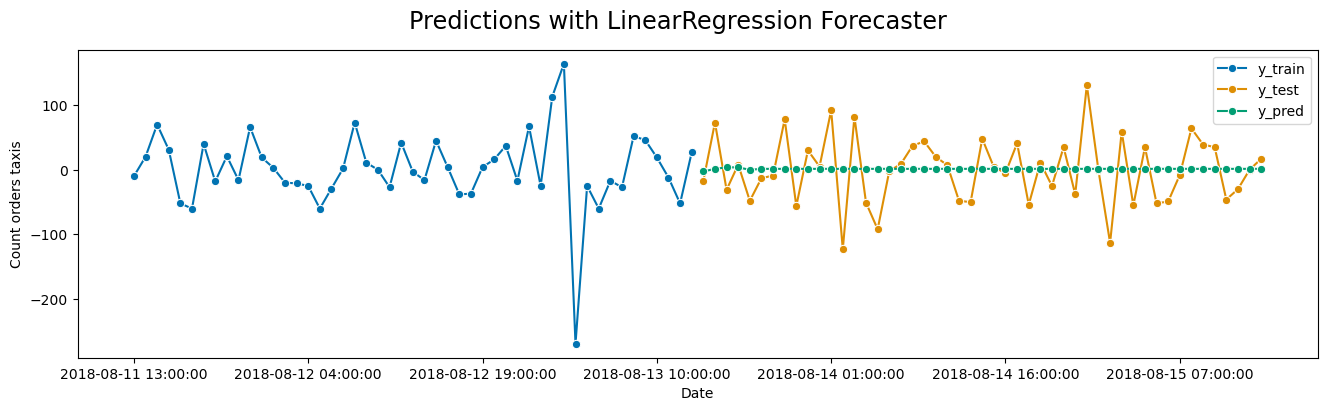

In [31]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbmf[start_test:end_test], 
            labels=["y_train", "y_test", "y_pred"], 
            x_label='Date', 
            y_label='Count orders taxis',
            title='Predictions with LinearRegression Forecaster');

Hemos entrenado el modelo Linear Regression Forecaster, obteniendo un score no tan bueno. La gráfica nos corrobora este ajuste.

## Análisis de modelos

In [32]:
summary_models

,model,rmse
1,LinearRegression,51.36
2,DecisionTreeRegressor,49.25
3,RandomForestRegressor,44.58
4,LGBMRegressor,42.48
5,LGBMRegressor Forecaster,58.87


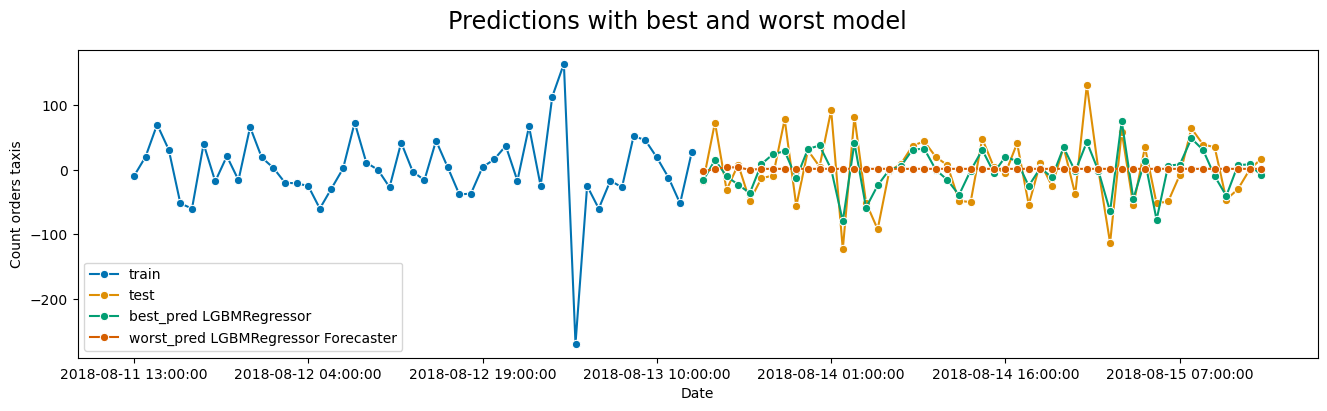

In [34]:
# Plot
plot_series(y_train[start_train:end_train], y_test[start_test:end_test], pred_lgbm[start_test:end_test], pred_lgbmf[start_test:end_test], 
            labels=["train", "test", "best_pred LGBMRegressor", "worst_pred LGBMRegressor Forecaster"], 
            x_label='Date', 
            y_label='Count orders taxis',
            title='Predictions with best and worst model');

Entrenamos 5 modelos predictivos para nuestra serie temporal. La tabla summary_models nos muestra por medio del RMSE como se ajustó cada modelo. El objetivo era lograr obtener un score máximo de 48, por lo que hemos cumplido con el objetivo, y obtuvimos que el modelo mejor ajustado es el LGBM Regressor.

## Conclusión

Realizamos análisis de estacionaridad a nuestra serie temporal y aplicamos diferenciación para convertir nuestra serie temporal a estacionaria.

Realizamos el entrenamiento de nuestros modelos para predecir las órdenes de taxi en la siguiente hora. Pudimos obtener un resumen de cada modelo con sus métricas y visualmente miramos como iban nuestras predicciones. 

Realizamos ajustes de hiperparámetros, y obtuvimos el mejor modelo con el siguiente detalle:
- algoritmo: `LGBMRegressor`
- hiperparámetros: 
    `'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 
    'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 
    'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 20, 'objective': None, 
    'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 
    'subsample_for_bin': 200000, 'subsample_freq': 0`
- Evaluación modelo, métrica RMSE: `42`

In [35]:
%load_ext watermark
%watermark

Last updated: 2023-06-03T16:37:25.689634-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.13.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

